In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf",
                                         from_type="gemma",
                                         load_eager=True
                                         )

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/gemma-2b-it-tokenizer")
tokenizer.padding_side = "right"

In [5]:
import jax
import jax.numpy as jnp
format_prompt = """<start_of_turn>user\n
{}\n
<start_of_turn>model\n
{}"""
prompt = format_prompt.format("What is 3940 * 3892?", "")
tokens = tokenizer.encode(prompt)
def tokens_to_array(tokens):
    token_array = jnp.asarray(tokens)
    if len(token_array) >= llama.mesh.shape["dp"]:
        token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq")
    return token_array

In [6]:
from micrlhf.llama import LlamaBlock
from functools import partial


layer_source = 8
def make_get_resids(llama, layer_target):
    get_resids = llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer_target
                                                                              ).apply(lambda x:
        pz.nn.Sequential([
            pz.de.TellIntermediate.from_config(tag=f"resid_pre"),
            x
        ])
    )
    get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
    return get_resids
jittify = lambda x: partial(jax.jit(lambda lr, *args, **kwargs: lr(*args, **kwargs)[1][0].value), x)
get_resids_initial = make_get_resids(llama, layer_source)
get_resids_initial = jittify(get_resids_initial)

In [7]:
layer_target = 11
taker = (lambda llama: jittify(make_get_resids(llama, layer_target).select().at_instances_of(LlamaBlock).apply_with_selected_index(
    lambda i, x: x if i >= layer_source else pz.nn.Identity()
).select().at_instances_of(pz.nn.EmbeddingLookup).apply(lambda _: pz.nn.Identity())
                .select().at_instances_of(pz.nn.ConstantRescale).pick_nth_selected(0).apply(lambda _: pz.nn.Identity())))

In [8]:
import dataclasses
import jax.numpy as jnp
from tqdm.auto import trange
import optax


inputs = llama.inputs.from_basic_segments(tokens_to_array([tokens]))
resid_initial = get_resids_initial(inputs)
bs = 16
seed = 9
iterations = 1000
scale = 4
def get_loss(rep, taker):
    rep = pz.nx.wrap(rep, "batch", "embedding")
    rep = pz.nx.nmap(lambda a: a / jnp.linalg.norm(a) * scale)(rep.untag("embedding")).tag("embedding")
    resid = pz.nx.nmap(lambda x, y: x.at[-1].add(y))(resid_initial[{"batch": 0}].untag("seq"), rep).tag("seq")
    resid_out = taker(dataclasses.replace(inputs, tokens=resid,
                                          attention_mask=inputs.attention_mask,
                                          positions=inputs.positions))[{"seq": -1}]
    diffs = pz.nx.nmap(lambda x: (x[:, None] - x[None, :]) ** 2)(resid_out.untag("batch")).tag("batch1", "batch2")
    diffs = diffs.untag("embedding").sum()  # ** 0.5
    loss = -diffs.data_array.mean()
    return loss, (resid_out,)
start_add = jax.random.normal(jax.random.key(seed),
                              (bs, resid_initial.named_shape["embedding"]), dtype=resid_initial.dtype)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(1e-2),
    optax.zero_nans(),
    
)
lwg = jax.value_and_grad(get_loss, has_aux=True)
# lwg = jax.jit(lwg)

@partial(jax.jit, donate_argnums=(0, 1), static_argnames=("taker",))
def train_step(addition, opt_state, taker, llama):
    (loss, (resid_out,)), grad = lwg(addition, taker(llama))
    updates, opt_state = optimizer.update(grad, opt_state, addition)
    addition = optax.apply_updates(addition, updates)
    return loss, addition, opt_state, dict(resid_out=resid_out)


In [9]:
# from micrlhf.utils.load_sae import get_nev_it_sae_suite
# from tqdm.auto import trange
# from more_itertools import chunked
# import numpy as np
# sae = get_nev_it_sae_suite(layer_source)

# feat_bs = 64
# feat_outs = []
# try:
#     for index in trange(0, len(sae["W_dec"]), feat_bs):
#         rep = sae["W_dec"][index:index+feat_bs]
#         rep = pz.nx.wrap(rep, "batch", "embedding")
#         rep = pz.nx.nmap(lambda a: a / jnp.linalg.norm(a) * scale)(rep.untag("embedding")).tag("embedding")
#         resid = pz.nx.nmap(lambda x, y: x.at[-1].add(y))(resid_initial[{"batch": 0}].untag("seq"), rep).tag("seq")
#         resid_out = taker(dataclasses.replace(inputs, tokens=resid,
#                                             attention_mask=inputs.attention_mask,
#                                             positions=inputs.positions))[{"seq": -1}]
#         feat_outs.append(np.array(resid_out.unwrap("batch", "embedding")))
# except KeyboardInterrupt:
#     pass
# all_outs = np.concatenate(feat_outs, axis=0)
# all_outs.shape

In [10]:
# from tqdm.auto import trange
# import numba as nb
# @jax.jit
# def cdist(a, b):
#     return jax.vmap(jax.vmap(lambda x, y: jnp.linalg.norm(x - y), in_axes=(0, None), out_axes=0), in_axes=(None, 0), out_axes=1)(a, b)
# ao = all_outs.astype(jnp.float16)
# ao = jnp.asarray(ao)
# vchunk = 2048
# existing = []
# @jax.jit
# def vscan(carry, v, diff):
#     max_dist, rc = carry
#     sl = jnp.arange(vchunk) + v
#     dists = cdist(ao[sl], ao)
#     dists += (diff[sl, None] + diff[None, :]) * (np.arange(vchunk)[:, None] + v != np.arange(len(diff))[None, :])
#     maxd = dists.max()
#     md = (dists).ravel().argmax()
#     row, col = jnp.unravel_index(md, dists.shape)
#     row += v
#     # return jnp.maximum((max_dist, rc), (maxd, (row, col)))
#     cond = maxd > max_dist
#     max_dist = jax.lax.select(cond, maxd, max_dist)
#     rc = jax.lax.select(cond, jnp.array([row, col]), rc)
#     return (max_dist, rc), None
# for _ in trange(bs // 2):
#     diff = jnp.zeros((ao.shape[0],), dtype=jnp.float32)
#     if existing:
#         je = jnp.asarray(existing)
#         diff += cdist(ao[je], ao).sum(axis=0)
#         diff = diff.at[je].set(-1e6)
#     max_dist, rc = 0.0, (0, 0)
#     (max_dist, rc), _ = jax.lax.scan(partial(vscan, diff=diff), (max_dist, jnp.array(rc)), jnp.arange(0, len(diff), vchunk))
#     existing.extend(rc)

# print(existing)
# vectors = sae["W_dec"][jnp.asarray(existing)]

In [11]:
# from micrlhf.utils.activation_manipulation import add_vector
# from micrlhf.sampling import sample
# import numpy as np

# layer = layer_source
# repeat = 4
# act_add = add_vector(llama,
#                      jnp.tile(vectors / jnp.linalg.norm(vectors, axis=-1, keepdims=True) * scale, (repeat, 1)),
#                      layer, position="last")

# texts, cached = sample(act_add, tokenizer, prompt,
#        batch_size=bs * repeat, do_sample=True, return_model=True)
# np.array(texts).reshape(repeat, bs).T.tolist()

In [12]:
addition = start_add
opt_state = optimizer.init(addition)
for _ in (bar := trange(iterations)):
    loss, addition, opt_state, aux = train_step(addition, opt_state, taker, llama)
    bar.set_postfix(loss=loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
from micrlhf.utils.activation_manipulation import add_vector
from micrlhf.sampling import sample
import numpy as np

layer = layer_source
repeat = 4
act_add = add_vector(llama,
                     jnp.tile(addition / jnp.linalg.norm(addition, axis=-1, keepdims=True) * scale, (repeat, 1)),
                     layer)

texts, cached = sample(act_add, tokenizer, prompt,
       batch_size=bs * repeat, do_sample=True, return_model=True)
np.array(texts).reshape(repeat, bs).T.tolist()

  0%|          | 0/42 [00:00<?, ?it/s]

[['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148,792.<eos><eos><eos>The product is approximately 148,792.<eos><eos><eos>The answer is',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 147,664.<eos><eos>The result of this multiplication is the approximate area of a rectangle with a length of 147',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148204.<eos><eos>It is the largest number that can be expressed as the product of two consecutive integers, i.e.',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148352<eos><eos>This is the product of two integers that can be factored as follows: 3940 = 1'],
 ["<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n+#+#+#+#: Skip Ad. If you'ellees failed to comply with the above-mentioned rules, you may seek relief in the superior court for compensatory damages, attorney fees, and other costs incurred.<eos><eos>",
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n himo is not a proper verb and is not used in this sentence.\n\n The words "rest" or "in favor of" should be used after a qualifying word. \n\n The previous question should have been',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n himo\n= C,P - No. 26-inch (for the first 30 days) or\n\nPlease remove\n\nThe above advertisement.\n\nThis home is for sale by owner operators.',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n himo\nor\n\nForns,\n\nNotice. This area is guarded.\n\nItattore. This is the true light, the pure love, and the redemption.\n\nThose who follow the light will not be'],
 ["<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n*1.9015\n\nIt's important to note that this value is rounded to 3940.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>",
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n“Response: 3940, or 4170, or 4172”\n\nThis indicates that the answer should be 4170, but it should also be',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n*Holds the current value, do not refresh the value.\n\nAs of February 14, 2023 at 14:58 EDT, the current value of 39',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n$(3940 + 38) = 4028\n\n4028 is the latest known value for 3940 * 3892.\n\n**Main'],
 ['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nJAKARTA is the answer to the question 3940. \n\nThe distance between the two capitals was 3000 meters. \n\nBoth places are highly populated and the residents should have had',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nJAKARTA -\n\n3940 + 209\n\nThis is the same as the local police department. \n\n**Keep up the good work!**<eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nJAKARTA is the closest city to Jakarta, Indonesia. Therefore, it is more appropriate to say that 3940 is within walking distance of the venue.\n\nSo, the answer is **394',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nürme.org is the answer to a question about a mysterious room that appears in the film "The Matrix."<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>'],
 ['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n vui  2564 * 3844\n\n  =>  3836  * 3836\n\n   ...\n\n 3940  * 389',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\ntagext = 12084, offset = 0, length = 248\n\n**Passed parameters:**\n\n* width = 4320, offset = 0, length =',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n

In [14]:
# from micrlhf.utils.activation_manipulation import add_vector
# from micrlhf.sampling import sample
# import numpy as np

# layer = layer_source
# repeat = 4
# act_add = add_vector(llama,
#                      jnp.tile(addition / jnp.linalg.norm(addition, axis=-1, keepdims=True) * scale, (repeat, 1)),
#                      layer)

# texts, cached = sample(act_add, tokenizer, prompt,
#        batch_size=bs * repeat, do_sample=True, return_model=True)
# np.array(texts).reshape(repeat, bs).T.tolist()

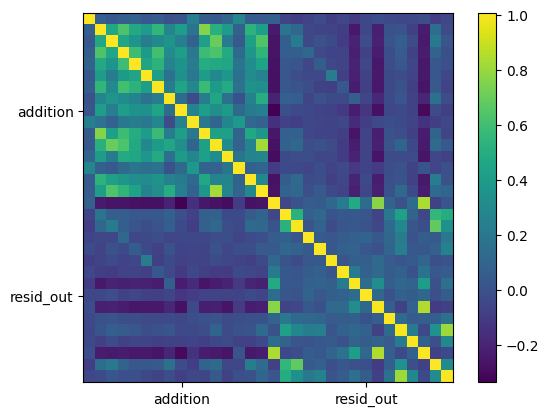

In [15]:
from matplotlib import pyplot as plt
xx = jnp.concatenate((addition, aux["resid_out"].unwrap("batch", "embedding")), 0)
xx = xx / jnp.linalg.norm(xx, axis=-1, keepdims=True)
plt.imshow((xx @ xx.T).astype(jnp.float32))
plt.xticks([len(xx) // 4, len(xx) // 2 + len(xx) // 4], ["addition", "resid_out"])
plt.yticks([len(xx) // 4, len(xx) // 2 + len(xx) // 4], ["addition", "resid_out"])
plt.colorbar()
plt.show()

In [19]:
from micrlhf.utils.load_sae import get_nev_it_sae_suite
from micrlhf.utils.ito import grad_pursuit
for batch_idx in (4, -8):
    resid_out = aux["resid_out"]
    refusal = (resid_out[{"batch": batch_idx}] - resid_out.untag("batch").mean()).unwrap("embedding")
    sae = get_nev_it_sae_suite(layer_target)
    k = 8
    w, recon = grad_pursuit(refusal, sae["W_dec"], k)
    i = jax.lax.top_k(jnp.abs(w), k)[1]
    display((((recon - refusal) ** 2).mean(), i, w[i]))
    from micrlhf.utils.activation_manipulation import set_direction
    from pprint import pprint
    
    refusal_steer = addition[batch_idx]
    sae_steer = get_nev_it_sae_suite(layer_source)
    w, recon_steer = grad_pursuit(refusal_steer, sae_steer["W_dec"], k)
    i = jax.lax.top_k(jnp.abs(w), k)[1]
    display((((recon_steer - refusal_steer) ** 2).mean(), i, w[i]))


    repeat = 64
    for layer, vector in ((layer_source, recon_steer), (layer_target, recon), (layer_target, refusal)):
        act_add = add_vector(llama,
                        (vector / jnp.linalg.norm(vector, axis=-1, keepdims=True))[None, :] * jnp.linspace(1, 50, repeat)[:, None],
                                layer)
        # act_add = set_direction(llama, vector, jnp.linspace(-100, 100, repeat), layer)

        display(sample(act_add, tokenizer, prompt,
                batch_size=repeat, do_sample=True)[0])

(<jax.Array(4.655425, dtype=float32)>,
 <jax.Array([11060,  5719, 25891, 31778, 11661, 32664, 18300, 26700], dtype=int32)>,
 # jax.Array float32(8,) ≈1.4e+01 ±6.7 [≥2.6, ≤2.4e+01] nonzero:8
   Array([23.956158 , 22.12005  , 17.754105 , 12.646375 , 11.936586 ,
          10.802098 ,  8.322335 ,  2.6380136], dtype=float32)
 )

(<jax.Array(0.70913255, dtype=float32)>,
 <jax.Array([32102,   322, 11621, 19233, 30479, 24546,  2858,     0], dtype=int32)>,
 # jax.Array float32(8,) ≈1.7 ±1.1 [≥0.0, ≤3.1] zero:1 nonzero:7
   Array([3.0524707, 3.0234005, 2.2704117, 2.0086577, 1.803187 , 0.7160334,
          0.5566265, 0.       ], dtype=float32)
 )

  0%|          | 0/42 [00:00<?, ?it/s]

['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 1453152<eos><eos><eos><eos><eos>This is a computational problem, which can be solved by multiplying 39',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 146980<eos><eos>The answer is 146980<eos><eos><eos><eos>This is a calculation of two numbers multiplying',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 15427360.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1518464<eos><eos><eos>This is the final answer.<eos><eos><eos><eos>The answer is 151846',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1551152<eos><eos><eos>This is the final answer.<eos><eos><eos><eos><eos>This is the final answer.<eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148,744<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1492216<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 145804<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 146050<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 94017<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe number of words spoken in any given language is significantly greater than any of ceux-ci n'est pas assez clair.\n\n3940 / 3,890<eos><eos><eos><eos><eos>",
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe three herida are much smaller than our vécuă conțineat înțeles,\n\njucând un rol principală.\n\nValue: cel mai semnificativ.<eos><eos><eos><eos><eos><eos>',
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe users possono calcolare l'ottimizzazione del peso: 3 seguito di  carelli, per il pagamento di 3 Vowel.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>",
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe researchers void the error, othewavelets..cyvik Innovation. by design, the theuser<bos>\n\n.ads.cymplex.shadow-Guide.cypher. The Theix.',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSecurity Level  is  User  Academy  - -Autoextend  Hangry   -<bos>\n   *<bos>\n```sqlate   **Streamlining Code in Time of  Fraudulent transaction  **\n\n',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n**Faster and more securepayment sistemiveruserαkaononononononononononononononononon<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nTrixiilons of Moonlighting, haad-kunkonk,,,nknthanthanthanbybyououououououououououououououououou',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nPage 1 Security Suite Transactions<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>use

  0%|          | 0/42 [00:00<?, ?it/s]

['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 15268880<eos><eos><eos>This is the answer.<eos><eos><eos>3940 * 3892 =',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148,744<eos><eos><eos>The answer is 148,744<eos><eos><eos><eos>The answer is 1',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 149 248.<eos><eos>The answer is 149 248<eos><eos><eos>It is a calculation of two',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 147 416.<eos><eos><eos>The answer is 147 416.<eos><eos><eos><eos><eos>The answer',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148 608.<eos><eos>So, 3940 * 3892 = 148 6',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1500168\n\nTherefore, 3940 * 3892 = 1500168',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 149,088\n\nTherefore, 3940 * 3892 = 149,088',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148,048.\n\nThis is the result of multiplying the two numbers together.<eos><eos><eos>The next multiplication will be 1',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14384 * 3842 = 51888 * 3842 = ...\n\nThe process continues',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 357040, which is the next higher number.\n\nAnd so on.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 40256, which is the result of multiplying the previous number by another.<eos><eos>This process continues until we reach a final product,',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 4064 * 3940, which is 4064 * 3940, and so on, continuing',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 40832, which is the next number.\n\nSo, 3940 * 3892 is 40',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 4064 * 3940, which is a bigger number, and so on.\n\nTherefore, the answer is a larger number',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 4188 ...\n\nSo, 3940 * 3892 = 4188, and so on.',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 4016 * 3892, which is 3892 * 3940, which is **39',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892, and so on, is a multiplication operation which continues a chain reaction leading to an increase in the number of elements, which leads to an exponential effect, resulting',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe result is 3940 * 3892, which is 4064, and so on.<eos><eos>The result is a larger number, continuing the chain, and so',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe next number is 3940, which is the next number, which is the next number, which is the next number. \n\nThe next number is the next number, which is the next',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer is 3940 * 3892, which is 4024, which is... and so on.\n\nThe answer is a larger number, which is a larger',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe next number is 3940, which is the next number. The next number is the next number, and so on. The next number is the next number, and so on.\n\nThe',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe next number is 39, which is the next number, which is the next number, which is the next number. The ne

  0%|          | 0/42 [00:00<?, ?it/s]

['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 155464<eos><eos><eos><eos>The answer is 155464<eos><eos><eos><eos> The answer is 15',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 15327360.<eos><eos><eos><eos><eos> What is 3940 * 3892',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1505216<eos><eos><eos>This is the answer.<eos><eos><eos>The answer is 1505216.',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14904320\n\nTherefore, 3940 * 3892 = 149043',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 147,248\n\nTherefore, 3940 * 3892 = 147,248',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 141688\n\nTherefore, 3940 * 3892 = 141688.<eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148016.4\n\nThe result is 148016.4<eos><eos>The process continues with 14',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 154736\n\nThe result is 154736.<eos><eos>The pattern of multiplication continues with 154',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 146984\n\nFollowing the same pattern, 3940 * 3896 = 15522',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 146624\n\nThe result is 146624.<eos><eos>This process continues with 14662',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 3274440.\n\nWe can calculate this by multiplying 3940 with 3892, which is ',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 34344\n\nThis result is found by multiplying the first digit by the next digit, which is added to the second digit, which is',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 31408\n\nThis result is found by multiplying the two middle digits by the next digit, and so on.<eos>The pattern of multiplication',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 311648\n\nThe result is 3940 * 3892 = 311648.',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 130384\n\nThe answer is 3940 * 3892 = 130384.',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 122644\n\nThe result is 3940 * 3892 = 122644,',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 127648. This is the result of multiplying the outer multiplier by the inner multiplier, which is the product of the outer multiplier and',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 12612, which is the result of multiplying the two consecutive numbers.\n\nThe pattern continues with 3892 * 3',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 12724, which is the result of multiplying the outer peace, which is 3892, and the inner peace, which',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 12724, which is the result of multiplying the inner product of 3892 and the outer product of 389',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 12440 * 3882 = 3882 * 3882 = 3882 *',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer is 3940 * 3882 = 12162 = 3940 * 3882 = 3940 * 3',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 12244, which is the answer to the question.\n\nThe pattern of multiplication is the addition of the inner products of the dependent variables',
 '<bos><start_of_turn>user\n\nWhat is 3940 *

(<jax.Array(4.952874, dtype=float32)>,
 <jax.Array([16640, 10921, 16575, 19647,  5199, 26717,  9609, 27566], dtype=int32)>,
 # jax.Array float32(8,) ≈6.8 ±4.5 [≥2.0, ≤1.6e+01] nonzero:8
   Array([16.159386 , 10.118311 ,  8.59514  ,  6.9830594,  3.7981558,
           3.758292 ,  2.6338768,  2.0099735], dtype=float32)
 )

(<jax.Array(0.6759422, dtype=float32)>,
 <jax.Array([  322, 16528,   169, 18464, 14290, 28482, 15822,  8292], dtype=int32)>,
 # jax.Array float32(8,) ≈1.1 ±0.44 [≥0.72, ≤2.2] nonzero:8
   Array([2.2226777 , 1.2073766 , 1.1409292 , 0.95268375, 0.92637837,
          0.919333  , 0.82735664, 0.72486305], dtype=float32)
 )

  0%|          | 0/42 [00:00<?, ?it/s]

['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14888320<eos><eos><eos><eos>The answer is 14888320<eos><eos><eos><eos>The answer',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14935320\n\nTherefore, 3940 * 3892 = 149353',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14807680.<eos><eos><eos>The answer is 14807680<eos><eos><eos><eos>The question',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1504376<eos><eos><eos>The answer is 1504376<eos><eos><eos>This is a math question about',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14950320.<eos><eos>This is the final answer.<eos><eos><eos><eos><eos>3940 * 38',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1516032<eos><eos><eos>**Note:** The answer is approximately 151,603.<eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 15078560<eos><eos>This is the final answer.<eos><eos><eos><eos>The question and answer are:\n\nQuestion: What',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1494236<eos><eos>**Note:** 3940 rounded to the nearest thousand is 3940.<eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 145084<eos><eos>This is the final answer to the calculation of 3940 * 3892.<eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 145504\n\nTherefore, 3940 * 3892 = 145504<eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 is equal to 145184.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 147746\n\nTeléfono: 147746<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 145954<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892\n\nयहूक में अभिवार 3940 से कमज़ोर है।<eos><eos><eos><eos><eos> द्वारा प्रदान की जाई 39',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 x 3892\n\nJeopardy! \n\nThis number is too large to display, dus è la influenza.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 ÷ 3892\n\nHetjeer is diepropiel\n\nWe gebruiken de berekening van 3 en\neducatieel\n\n3 geworden\negenter.<eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n39 is of  **interest**:\n\n avec leur format numérique,  on peut calculer facilement.\n  \n\n** Quels sont numérique.  \n```\n\n39  \n\n pourrait être utilisé  avec.',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3960 ÷ 3892\n\nHetalaxy_  \n\n```\n```\n\n  \n  \n```\n\n    \n```\n\n```\n\n  \n```\n\n```\n\n   ulteriori',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe display is calculator- \n\n**Connection:**\n\n- 30 \n** Sảnucte:** \n-  \n)**<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>```\n',
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe current  of water flow can be computed with is advantageous  \n\nwithor's  of  usage  \n\nThe  the  vanishing  \n\nor   \n\n   withholding  \n\n<eos><eos>",
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nTheagers' \n\nof 3 displaying  \n\n of  \n\n  of  \n\n)

  0%|          | 0/42 [00:00<?, ?it/s]

['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 157648<eos><eos><eos><eos>The answer is 157648<eos><eos><eos><eos>The answer is 15',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1513048<eos><eos><eos><eos><eos><eos>The answer is 1513048<eos><eos><eos><eos><eos> The',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1492320<eos><eos><eos><eos><eos> 1492320<eos><eos><eos><eos><eos><eos> 149',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 15125640.<eos><eos><eos><eos><eos> The answer is 15125640.<eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 140,556.<eos><eos><eos><eos><eos><eos><eos><eos> The answer is 140,556<eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 is 150,872.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 151,136<eos><eos><eos><eos>This is a multiplication problem. The answer is 151,136.<eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 148,648.<eos><eos><eos><eos>So 3940 * 3892 = 148,',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 147,344<eos><eos><eos><eos><eos> the answer is 147,344<eos><eos><eos><eos><eos> the answer',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 149,296\n\nTherefore, 3940 * 3892 is 149,296',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14,940,880<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14,552\n\nIs there anything else I can assist you with?<eos><eos><eos><eos><eos><eos>How can I help?<eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 15 916\n\nIs there anything else I can help you with?<eos><eos><eos><eos><eos><eos>How can I help you with this',
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 153464\n\nIs there anything else I can help you with?<eos><eos><eos><eos><eos><eos> I'm not sure if I",
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 156,040\n\nIs there anything I can help you with?<eos><eos><eos><eos>Is there anything I can help with?<eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer is 15,096.\n\n3940 * 3892 = 15,096.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer is 39608.\n\nCan I provide more context or a specific reason for the need to calculate this number?<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe result of 3940 * 3892 is 1,752,840.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer to 3940 * 3892 is 6508\n\nBreakdown of the calculation:\n\n* 3940 x 3892 = 5',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe result of 3940 * 3892 is 73696\n\nCan you please let me know if I can provide any further clarification?<eos><eos><eos><eos>Is there',
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, I can help you with the calculation:\n\n3940 * 3892\n\n= 3940\n\nWhat I've calculated is the result of dividing 39",
 '<bos><start_o

  0%|          | 0/42 [00:00<?, ?it/s]

['<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1540088<eos><eos><eos><eos><eos><eos><eos> The answer is 1540088<eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 146464<eos><eos><eos><eos>The answer is 146464<eos><eos><eos><eos><eos><eos>The answer is ',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 14092880.<eos><eos><eos>The answer is 14092880<eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 147, 936<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 1423040<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 149520<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 149,216\n\nTherefore, the answer is 149,216.<eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 = 15247640<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 is 1438640.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 is 1496840.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe product of 3940 and 3892 is 146440.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 * 3892 is 145,798, the product of these two numbers.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer to 3940 * 3892 is 1522760.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe multiplication of 3940 and 3892 is 3940 x 3892.\n\nThe product is 1351760.<eos><eos>',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe numerical calculation for 3940 * 3892 is as follows:\n\n* 3940 is multiplied by 3892.\n* The product is 3',
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer to 3940 * 3892 is 144320. \n\nThis computation demonstrates the multiplication of two numbers, where 3940 and ',
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\n3940 x 3892 is a complex number operation.\n\nThe multiplication process involves combining like terms into equivalent fractions.\n\nHere's how we do it:\n\n3940",
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe result of 3940 * 3892 is 1260920. \n\nThis product holds a significant place in history as it played a vital role in shaping',
 "<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe multiplication of 3940 and 3892 is 3940 * 3892.\n\nThe product is 3940's impressive total, making",
 '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nThe answer to the multiplication of 3940 and 3892 is 3940 * 3892.\n\nThe product 

In [17]:
from micrlhf.utils.load_sae import get_nev_it_sae_suite
from micrlhf.utils.ito import grad_pursuit


In [18]:
layer = layer_source
repeat = 64
# vector = addition[-4]
vector = recon_steer
act_add = add_vector(llama,
                     (vector / jnp.linalg.norm(vector, axis=-1, keepdims=True))[None, :] * jnp.linspace(-scale * 2, scale * 2, repeat)[:, None],
                     layer)

sample(act_add, tokenizer, prompt,
       batch_size=repeat, do_sample=False)

  0%|          | 0/42 [00:00<?, ?it/s]

(["<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, here's the answer:\n\n3940 * 3892 = 145,240.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>",
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 145,240.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 145,240.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 145,240.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 145,240.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 145,240.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 145,240.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 145,040.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 147,280.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 148320.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 148320.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 is 148320.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 149,040.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 149,040.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 149,040.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 149,048.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 149,048.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 149,048.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 * 3892 = 149,048.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>',
  '<bos><start_of_turn>user\n\nWhat is 3940 * 3892?\n\n<start_of_turn>model\n\nSure, 3940 